# Import library files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#ML Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import f1_score,accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report,confusion_matrix
from  mlxtend.plotting import plot_confusion_matrix


# Data understanding

In [3]:
df = pd.read_csv('/content/earthquake_data.csv')
df.head().T
df1=df.copy()

In [4]:
alerts = df["alert"].unique()

In [5]:
df.head()

,title,magnitude,date_time,cdi,mmi,alert,Earthquake,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,continent,country
0,"M 7.0 - 18 km SW of Malango, Solomon Islands",7.0,22-11-2022 02:03,8,7,green,1,768,us,117,0.509,17.0,mww,14.000,-9.7963,159.596,"Malango, Solomon Islands",Oceania,Solomon Islands
1,"M 6.9 - 204 km SW of Bengkulu, Indonesia",6.9,18-11-2022 13:37,4,4,green,0,735,us,99,2.229,34.0,mww,25.000,-4.9559,100.738,"Bengkulu, Indonesia",NaN,NaN
2,M 7.0 -,7.0,12-11-2022 07:09,3,3,green,1,755,us,147,3.125,18.0,mww,579.000,-20.0508,-178.346,NaN,Oceania,Fiji
3,"M 7.3 - 205 km ESE of Neiafu, Tonga",7.3,11-11-2022 10:48,5,5,green,1,833,us,149,1.865,21.0,mww,37.000,-19.2918,-172.129,"Neiafu, Tonga",NaN,NaN
4,M 6.6 -,6.6,09-11-2022 10:14,0,2,green,1,670,us,131,4.998,27.0,mww,624.464,-25.5948,178.278,NaN,NaN,NaN


In [6]:
df.columns

Index(['title', 'magnitude', 'date_time', 'cdi', 'mmi', 'alert', 'Earthquake',
       'sig', 'net', 'nst', 'dmin', 'gap', 'magType', 'depth', 'latitude',
       'longitude', 'location', 'continent', 'country'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       782 non-null    object 
 1   magnitude   782 non-null    float64
 2   date_time   782 non-null    object 
 3   cdi         782 non-null    int64  
 4   mmi         782 non-null    int64  
 5   alert       415 non-null    object 
 6   Earthquake  782 non-null    int64  
 7   sig         782 non-null    int64  
 8   net         782 non-null    object 
 9   nst         782 non-null    int64  
 10  dmin        782 non-null    float64
 11  gap         782 non-null    float64
 12  magType     782 non-null    object 
 13  depth       782 non-null    float64
 14  latitude    782 non-null    float64
 15  longitude   782 non-null    float64
 16  location    777 non-null    object 
 17  continent   206 non-null    object 
 18  country     484 non-null    object 
dtypes: float64(6), int64(5), obje

In [8]:
df.isna().sum()

title           0
magnitude       0
date_time       0
cdi             0
mmi             0
alert         367
Earthquake      0
sig             0
net             0
nst             0
dmin            0
gap             0
magType         0
depth           0
latitude        0
longitude       0
location        5
continent     576
country       298
dtype: int64

In [9]:
for val in df.columns:
    if len(pd.unique(df[val]))<100:
        print('*'*10,val,'*'*10)
        print(pd.unique(df[val]))

********** magnitude **********
[7.   6.9  7.3  6.6  6.8  6.7  7.6  6.5  7.2  7.5  7.1  8.1  8.2  7.4
 7.7  7.8  8.   7.9  8.3  8.6  9.1  8.8  8.4  8.16]
********** cdi **********
[8 4 3 5 0 1 7 9 2 6]
********** mmi **********
[7 4 3 5 2 6 8 9 1]
********** alert **********
['green' 'yellow' 'orange' 'red' nan]
********** Earthquake **********
[1 0]
********** net **********
['us' 'at' 'pt' 'ak' 'nn' 'ci' 'hv' 'nc' 'official' 'duputel' 'uw']
********** magType **********
['mww' 'mwb' 'Mi' 'ml' 'mw' 'mwc' 'ms' 'mb' 'md']
********** continent **********
['Oceania' nan 'North America' 'Asia' 'South America' 'Europe' 'Africa']
********** country **********
['Solomon Islands' nan 'Fiji' 'Panama' 'Mexico' 'Taiwan'
 'Papua New Guinea' "People's Republic of China" 'Philippines' 'Brazil'
 'Peru' 'Argentina' 'Indonesia' 'United States of America' 'Antarctica'
 'Vanuatu' 'Haiti' 'Japan' 'Mongolia' 'Greece' 'Chile' 'Russia' 'Turkey'
 'United Kingdom of Great Britain and Northern Ireland (the)' 'E

# Data Cleaning

In [10]:
def nullValues(df):
    total=df.isnull().sum()
    percent=df.isnull().sum()/df.isnull().count()*100
    null_df=pd.concat([total,percent],axis=1,keys=["Total","Percent"])
    null_df=null_df[null_df["Percent"]>0]
    null_df=null_df.sort_values(by="Percent",ascending=False)
    print(pd.DataFrame(null_df))
    plt.figure(figsize=(16,10))
    sns.barplot(x=null_df.index,y=null_df["Percent"],color="g")
    plt.xticks(rotation=90)
    plt.xlabel("Null_value_Column")
    plt.ylabel("Percent")

           Total    Percent
continent    576  73.657289
alert        367  46.930946
country      298  38.107417
location       5   0.639386


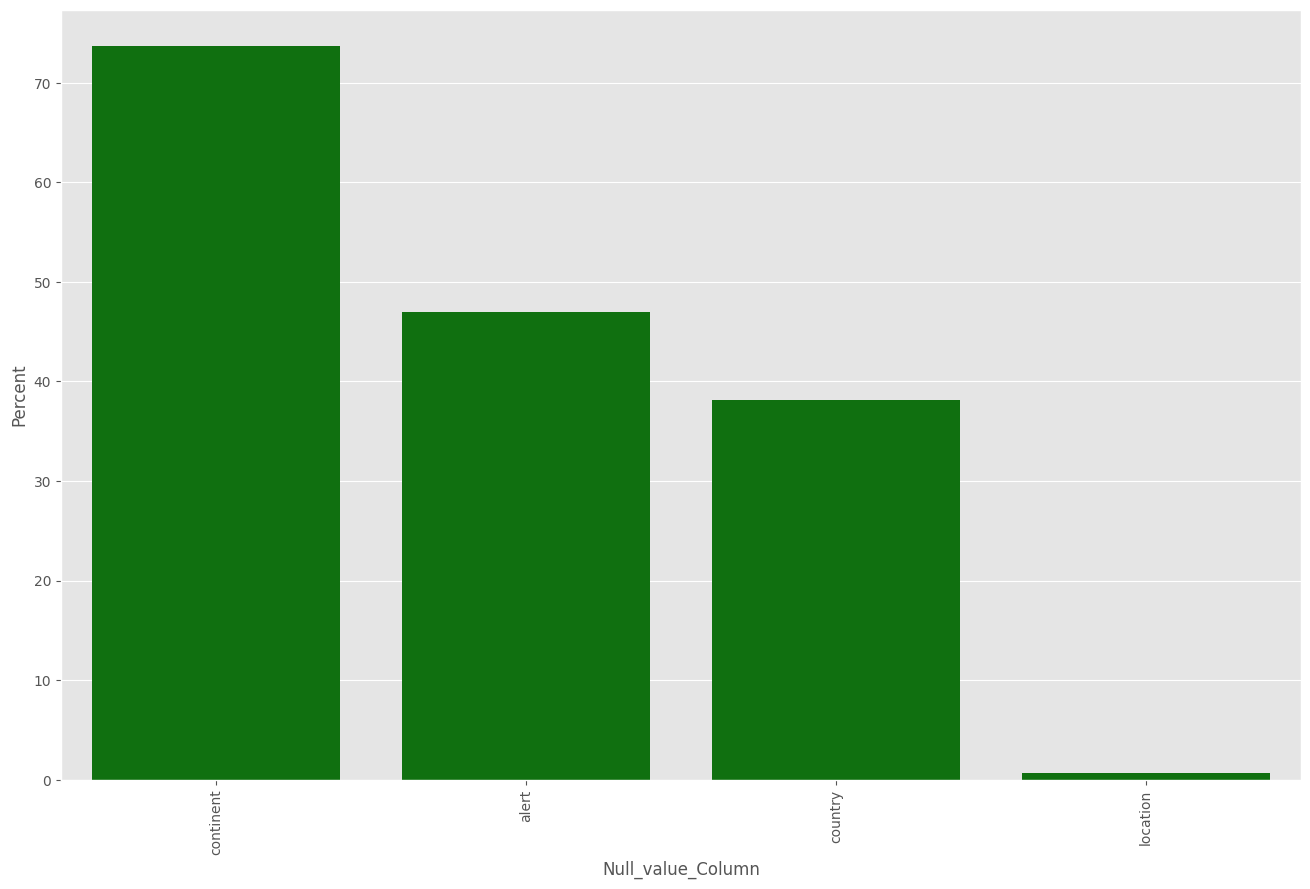

In [11]:
nullValues(df)

In [12]:
df.columns

Index(['title', 'magnitude', 'date_time', 'cdi', 'mmi', 'alert', 'Earthquake',
       'sig', 'net', 'nst', 'dmin', 'gap', 'magType', 'depth', 'latitude',
       'longitude', 'location', 'continent', 'country'],
      dtype='object')

In [13]:
# # Defining the columns #

# CDI (Community Determined Intensity) is based on reports from individuals who felt the earthquake, and takes 
# into account the physical characteristics of the earthquake as well as the human experience of the earthquake.

# MMI (Modified Mercalli Intensity) is also based on reports from individuals who felt the earthquake, and takes
# into account a range of factors such as the strength of shaking, damage to buildings and infrastructure, and the
# emotional response of people.

# 'sig': short for 'magnitude significance', this is a measure of the relative strength of an earthquake event.
# It is calculated based on the magnitude of the earthquake, the number of seismic stations reporting the event, 
# and the distance between the event and those stations.

# 'net': short for 'seismic network', this refers to the network of seismometers and other seismic sensors used 
# to detect and record seismic events. Each seismic network has its own specific characteristics and capabilities, 
# which can affect the accuracy and completeness of earthquake detection and location.

# 'nst': short for 'number of seismic stations', this is the number of seismic stations that detected and recorded 
# an earthquake event. The more seismic stations that detect an event, the more accurately its location and other 
# attributes can be determined.

# 'dmin': short for 'minimum distance', this is the shortest distance between the earthquake event and the 
# nearest seismic station that detected it. This distance can affect the accuracy of the earthquake's location 
# and other attributes, as well as the strength of the seismic waves detected by the station.

# 'gap' refers to the azimuthal gap between the seismic stations that record an earthquake. The azimuthal gap 
# is the angle between the two most widely spaced seismic stations recording the earthquake. A large gap can 
# indicate that important seismic data is missing, which can make it more difficult to accurately determine the 
# earthquake's location, magnitude, and other characteristics.

# 'magType' refers to the type of magnitude calculation used to determine the size of the earthquake. There are 
# several different types of magnitude calculations, including Richter magnitude, moment magnitude, and surface 
# wave magnitude. Each type of magnitude calculation takes into account different aspects of the earthquake, such 
# as the amplitude of the seismic waves or the energy released by the earthquake. The choice of magnitude type can 
# affect the reported magnitude value and can also affect earthquake hazard assessments and emergency response planning.



In [14]:
features = ["longitude","latitude", "depth", "cdi", "mmi", "sig","dmin","nst","gap" ]
target = "alert"

df = df[features + [target]]

In [15]:
df.isna().sum()

longitude      0
latitude       0
depth          0
cdi            0
mmi            0
sig            0
dmin           0
nst            0
gap            0
alert        367
dtype: int64

In [16]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 0 to 507
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   longitude  415 non-null    float64
 1   latitude   415 non-null    float64
 2   depth      415 non-null    float64
 3   cdi        415 non-null    int64  
 4   mmi        415 non-null    int64  
 5   sig        415 non-null    int64  
 6   dmin       415 non-null    float64
 7   nst        415 non-null    int64  
 8   gap        415 non-null    float64
 9   alert      415 non-null    object 
dtypes: float64(5), int64(4), object(1)
memory usage: 35.7+ KB


# Data Preprocessing
---

In [17]:
for val in df.columns:
    print('*'*10,val,'*'*10)
    print(df[val].value_counts())

********** longitude **********
 159.5960    1
 167.3030    1
 138.5280    1
 158.0530    1
 157.8770    1
            ..
 126.7580    1
 166.8750    1
-71.3815     1
 42.3568     1
-115.2950    1
Name: longitude, Length: 415, dtype: int64
********** latitude **********
-9.7963     1
-14.8595    1
-2.6286     1
-9.3438     1
-9.3293     1
           ..
 2.2580     1
-13.3360    1
-30.0404    1
-43.1219    1
 32.2862    1
Name: latitude, Length: 415, dtype: int64
********** depth **********
10.000     54
20.000     17
12.000     10
35.000     10
24.000     10
           ..
540.000     1
461.000     1
550.000     1
576.000     1
9.987       1
Name: depth, Length: 213, dtype: int64
********** cdi **********
0    62
8    59
9    55
5    54
7    51
6    47
4    33
3    28
1    14
2    12
Name: cdi, dtype: int64
********** mmi **********
6    99
7    92
5    68
4    65
8    40
3    34
9    12
2     4
1     1
Name: mmi, dtype: int64
********** sig **********
650     22
670     16
691     13
7

## Balancing

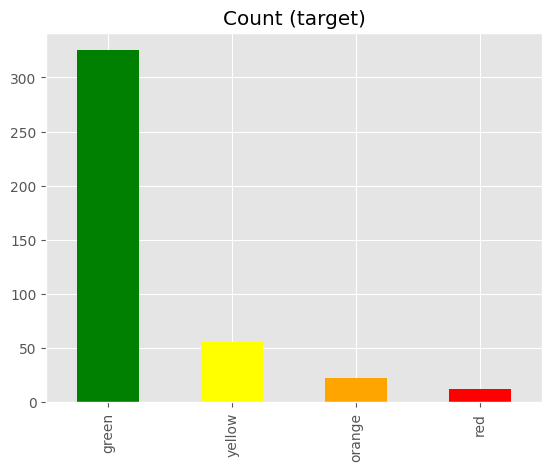

In [18]:
df[target].value_counts().plot(kind='bar', title='Count (target)', color=['green', 'yellow', 'orange', 'red']);

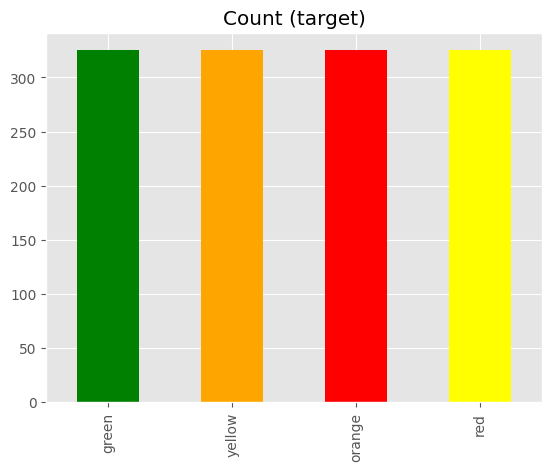

In [19]:
X = df[features]
y = df[target]

X = X.loc[:,~X.columns.duplicated()]


sm = SMOTE(random_state=42)
X_res, y_res= sm.fit_resample(X, y,)

y_res.value_counts().plot(kind='bar', title='Count (target)', color=['green', 'orange', 'red', 'yellow']);

## Splitting & Scaling

In [20]:
X_res.columns

Index(['longitude', 'latitude', 'depth', 'cdi', 'mmi', 'sig', 'dmin', 'nst',
       'gap'],
      dtype='object')

In [21]:
X_res.head(5).T

,0,1,2,3,4
longitude,159.5960,100.7380,-178.3460,-172.1290,178.2780
latitude,-9.7963,-4.9559,-20.0508,-19.2918,-25.5948
depth,14.0000,25.0000,579.0000,37.0000,624.4640
cdi,8.0000,4.0000,3.0000,5.0000,0.0000
mmi,7.0000,4.0000,3.0000,5.0000,2.0000
sig,768.0000,735.0000,755.0000,833.0000,670.0000
dmin,0.5090,2.2290,3.1250,1.8650,4.9980
nst,117.0000,99.0000,147.0000,149.0000,131.0000
gap,17.0000,34.0000,18.0000,21.0000,27.0000


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


In [23]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Exploratory Analysis
---

Text(0.5, 1.0, 'MMI')

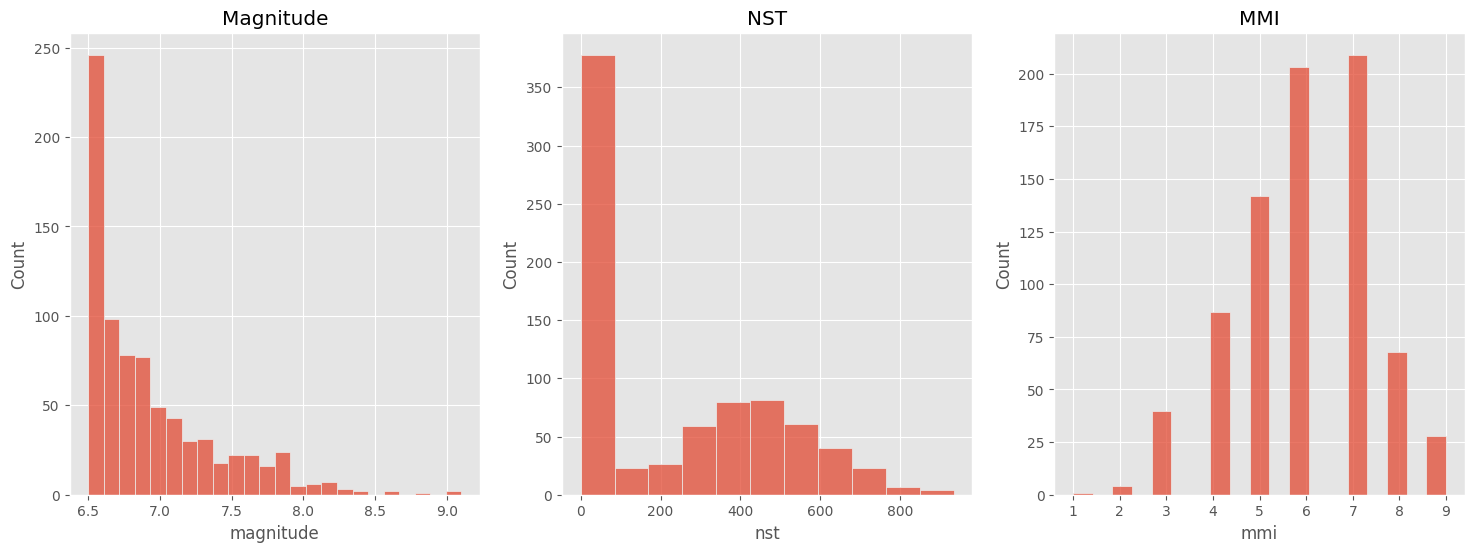

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=100)

sns.histplot(data = df1, x = 'magnitude', ax=axes[0])
axes[0].set_title("Magnitude")

sns.histplot(data = df1, x = 'nst', ax=axes[1])
axes[1].set_title("NST")

sns.histplot(data = df1, x = 'mmi', ax=axes[2])
axes[2].set_title("MMI")

Text(0.5, 1.0, 'Depth')

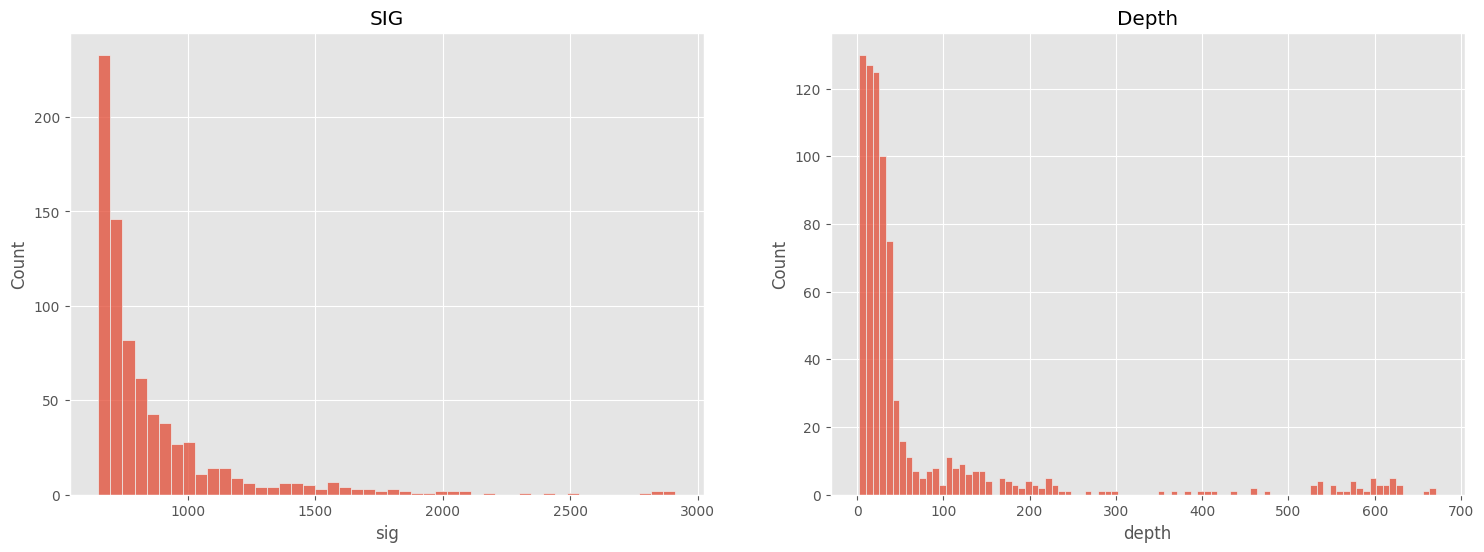

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), dpi=100)

sns.histplot(data = df1, x = 'sig', ax=axes[0])
axes[0].set_title("SIG")

sns.histplot(data = df1, x = 'depth', ax=axes[1])
axes[1].set_title("Depth")

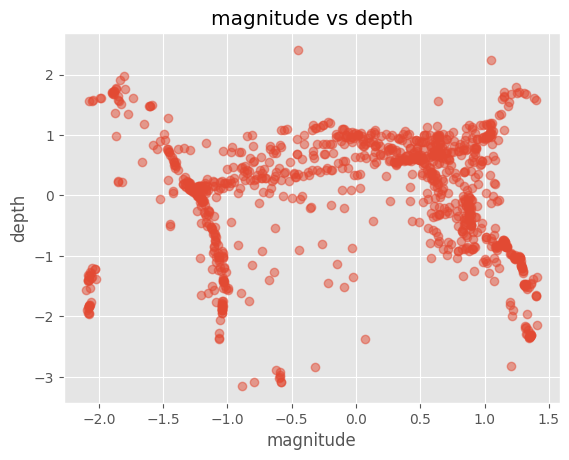

In [26]:
plt.plot(X_train[:, 0], X_train[:, 1], 'o', alpha=0.5)
plt.xlabel('magnitude')
plt.ylabel('depth')
plt.title('magnitude vs depth');
plt.show()


<Axes: >

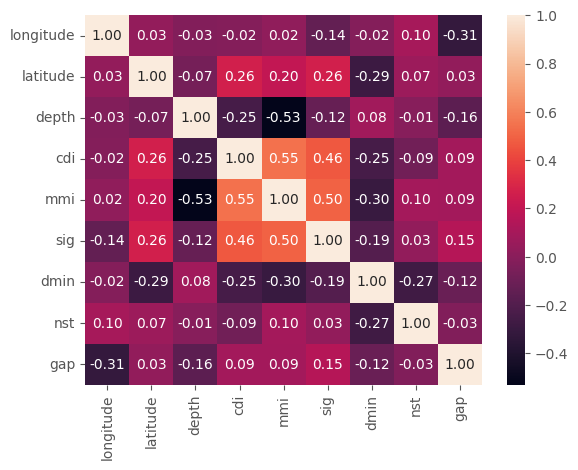

In [27]:
sns.heatmap(df.corr(), annot=True, fmt=".2f")


# Modelling
---

In [28]:
models = []

In [29]:
from matplotlib.colors import ListedColormap
from sklearn import metrics

In [30]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
models.append(dt)

In [31]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
models.append(knn)



In [32]:
svm = SVC(random_state=42)
svm.fit(X_train, y_train)
models.append(svm)


In [33]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
models.append(rf)


In [34]:
print(models)

[DecisionTreeClassifier(random_state=42), KNeighborsClassifier(), SVC(random_state=42), RandomForestClassifier(random_state=42)]


In [35]:
X_train.shape

(1040, 9)

## Evaluation of Models

In [36]:
Name = [type(model).__name__ if type(model).__name__ != 'SVC' else 'SVM' for model in models]

accuracy = [accuracy_score(y_test, model.predict(X_test)) for model in models]
precision = [precision_score(y_test, model.predict(X_test), average='weighted') for model in models]
recall = [recall_score(y_test, model.predict(X_test), average='weighted') for model in models]
f1_scores = [f1_score(y_test, model.predict(X_test), average='weighted') for model in models]

In [37]:

Dict = {'Name':Name,'Accuracy':accuracy,'Precision_score':precision,'Recall_score':recall,'F1_score':f1_scores}
model_df = pd.DataFrame(Dict)
model_df

,Name,Accuracy,Precision_score,Recall_score,F1_score
0,DecisionTreeClassifier,0.942308,0.941710,0.942308,0.941875
1,KNeighborsClassifier,0.923077,0.934314,0.923077,0.923851
2,SVM,0.930769,0.945339,0.930769,0.932321
3,RandomForestClassifier,0.976923,0.977345,0.976923,0.976927


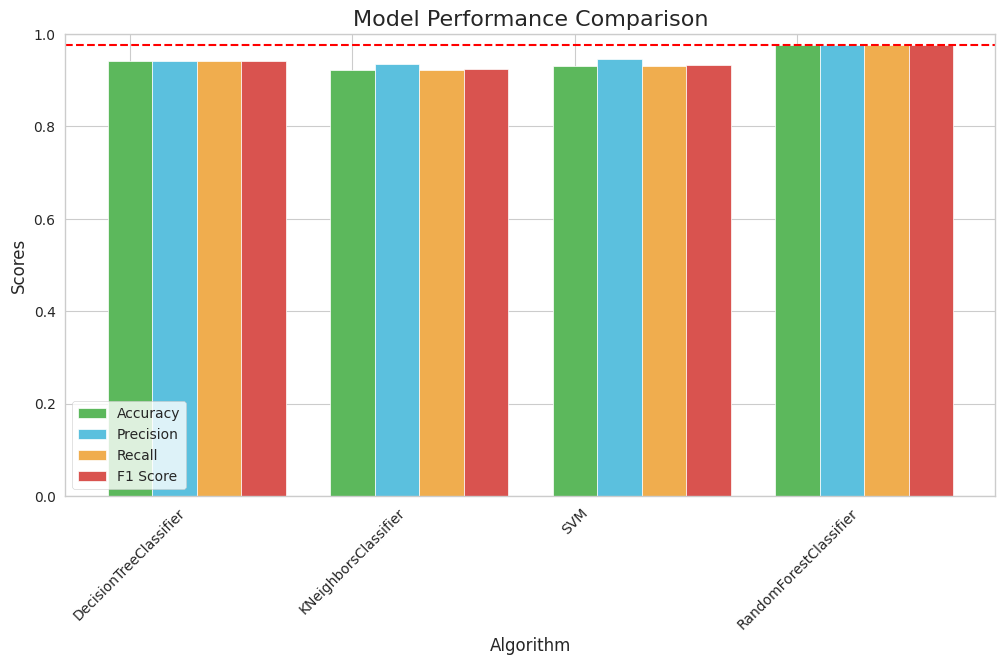

In [40]:
import numpy as np
import matplotlib.pyplot as plt

algorithm_names = ['DecisionTreeClassifier', 'KNeighborsClassifier', 'SVM', 'RandomForestClassifier']
xpos = np.arange(len(algorithm_names))


colors = ['#5cb85c', '#5bc0de', '#f0ad4e', '#d9534f']  # specify colors for each bar

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(xpos, accuracy, width=0.2, label="Accuracy", color=colors[0])
ax.bar(xpos + 0.2, precision, width=0.2, label="Precision", color=colors[1])
ax.bar(xpos + 0.4, recall, width=0.2, label="Recall", color=colors[2])
ax.bar(xpos + 0.6, f1_scores, width=0.2, label="F1 Score", color=colors[3])

ax.set_xticks(xpos)
ax.set_xticklabels(algorithm_names, rotation=45)
ax.set_xlabel("Algorithms")
plt.ylabel('Value', fontsize=12)
plt.xlabel('Algorithm', fontsize=12)
plt.title('Model Performance Comparison', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
ax.set_ylabel("Scores")
ax.set_ylim([0, 1])
ax.axhline(max(precision), color='r', linestyle='--')
ax.legend()

plt.show()


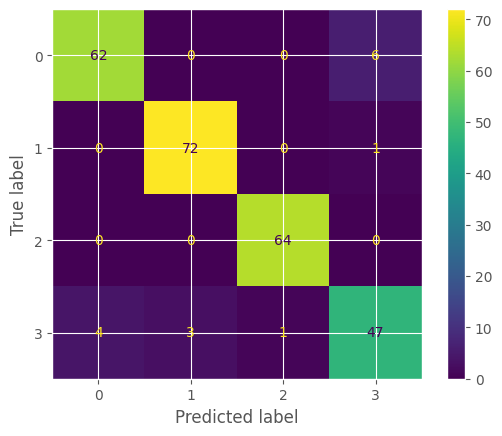

In [ ]:
#DecisionTreeClassifier
dty_pred = dt.predict(X_test)
# Obtain the confusion matrix
cm = metrics.confusion_matrix(y_test, dty_pred)


# create the display object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

# plot the confusion matrix
cm_display.plot()

In [ ]:
report = classification_report(y_test, dty_pred)

print(report)

              precision    recall  f1-score   support

       green       0.94      0.91      0.93        68
      orange       0.96      0.99      0.97        73
         red       0.98      1.00      0.99        64
      yellow       0.87      0.85      0.86        55

    accuracy                           0.94       260
   macro avg       0.94      0.94      0.94       260
weighted avg       0.94      0.94      0.94       260



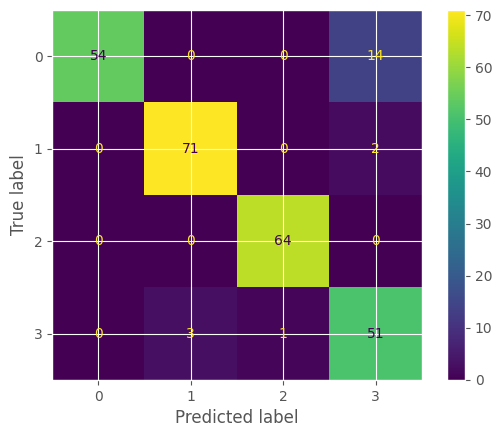

In [ ]:
#KNeighborsClassifier
kny_pred = knn.predict(X_test)

# Obtain the confusion matrix
cm = confusion_matrix(y_test, kny_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

# plot the confusion matrix
cm_display.plot()

In [ ]:
report = classification_report(y_test, kny_pred)

print(report)

              precision    recall  f1-score   support

       green       1.00      0.79      0.89        68
      orange       0.96      0.97      0.97        73
         red       0.98      1.00      0.99        64
      yellow       0.76      0.93      0.84        55

    accuracy                           0.92       260
   macro avg       0.93      0.92      0.92       260
weighted avg       0.93      0.92      0.92       260



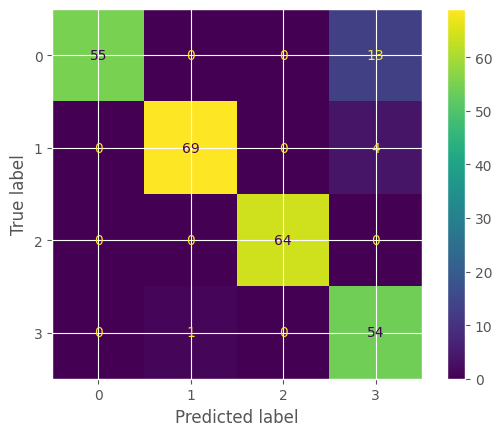

In [ ]:
#SVM
svy_pred = svm.predict(X_test)

# Obtain the confusion matrix
cm = confusion_matrix(y_test, svy_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

# plot the confusion matrix
cm_display.plot()


In [ ]:
report = classification_report(y_test, svy_pred)

print(report)

              precision    recall  f1-score   support

       green       1.00      0.81      0.89        68
      orange       0.99      0.95      0.97        73
         red       1.00      1.00      1.00        64
      yellow       0.76      0.98      0.86        55

    accuracy                           0.93       260
   macro avg       0.94      0.93      0.93       260
weighted avg       0.95      0.93      0.93       260



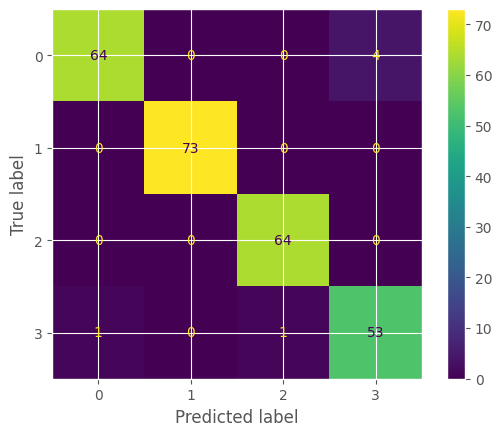

In [ ]:
#RandomForestClassifier	
rfy_pred = rf.predict(X_test)

# Obtain the confusion matrix
cm = confusion_matrix(y_test, rfy_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

# plot the confusion matrix
cm_display.plot()

In [ ]:
report = classification_report(y_test, svy_pred)

print(report)

              precision    recall  f1-score   support

       green       1.00      0.81      0.89        68
      orange       0.99      0.95      0.97        73
         red       1.00      1.00      1.00        64
      yellow       0.76      0.98      0.86        55

    accuracy                           0.93       260
   macro avg       0.94      0.93      0.93       260
weighted avg       0.95      0.93      0.93       260



#i.e **RandomForestClassifier**

In [ ]:
#Rebuilding the best models 
#i.e RandomForestClassifier 
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
X_res

,longitude,latitude,depth,cdi,mmi,sig,dmin,nst,gap
0,159.596000,-9.796300,14.000000,8,7,768,0.509000,117,17.000000
1,100.738000,-4.955900,25.000000,4,4,735,2.229000,99,34.000000
2,-178.346000,-20.050800,579.000000,3,3,755,3.125000,147,18.000000
3,-172.129000,-19.291800,37.000000,5,5,833,1.865000,149,21.000000
4,178.278000,-25.594800,624.464000,0,2,670,4.998000,131,27.000000
...,...,...,...,...,...,...,...,...,...
1295,-49.945540,-28.300916,26.928511,9,7,1696,0.308319,66,35.999831
1296,153.596611,-4.583648,96.369547,9,7,972,1.490109,0,12.819125
1297,-76.877601,-2.670949,141.767409,7,7,1142,2.018211,0,15.764642
1298,-91.895195,14.317741,55.504201,6,6,956,0.581136,0,41.117683


In [ ]:
def model_final(scaler,rf):
    longitude = float(input('enter the logitude '))
    latitude = float(input('enter the latitude '))
    depth = float(input('enter depth '))
    cdi = float(input('enter cdi '))
    mmi = float(input('enter mmi '))
    sig = float(input('enter sig '))
    dmin =float(input('enter dmin '))
    nst =float(input('enter nst '))
    gap=float(input('enter gap '))
    data = {'longitude':longitude, 'latitude':latitude, 'depth':depth, 'cdi':cdi, 'mmi':mmi, 'sig':sig,'dmin':dmin,'nst':nst,'gap':gap}
    df = pd.DataFrame(data, index=[0])
    detect=scaler.transform(df)
    val=rf.predict(detect)    
    if val=='orange':
        print('high magnitude earthquakes')
    elif val=='green':
        print('low magnitude earthquakes')
    elif val=='yellow':
        print('medium magnitude earthquakes')
    elif val=='red':
        print('very high magnitude earthquakes')

In [ ]:
#-178.3460,-20.0508,579,3,3,-13,579,green

In [ ]:
model_final(scaler,rf)

enter the logitude 159.0270
enter the latitude -54.1325
enter depth 10.000
enter cdi 2
enter mmi 5
enter sig 733
enter dmin 0.371
enter nst 127
enter gap 45.0
low magnitude earthquakes


In [ ]:
# the color defines the alerts levels
# green :-  low magnitude earthquakes
# yellow :- medium magnitude earthquakes
# orange :- high magnitude earthquakes
# red :- very high magnitude earthquakes

In [ ]:
df.head(50)

,longitude,latitude,depth,cdi,mmi,sig,dmin,nst,gap,alert
0,159.5960,-9.7963,14.000,8,7,768,0.509,117,17.0,green
1,100.7380,-4.9559,25.000,4,4,735,2.229,99,34.0,green
2,-178.3460,-20.0508,579.000,3,3,755,3.125,147,18.0,green
3,-172.1290,-19.2918,37.000,5,5,833,1.865,149,21.0,green
4,178.2780,-25.5948,624.464,0,2,670,4.998,131,27.0,green
5,178.3810,-26.0442,660.000,4,3,755,4.578,142,26.0,green
6,178.3630,-25.9678,630.379,1,3,711,4.678,136,22.0,green
7,-82.3396,7.6712,20.000,7,6,797,1.151,145,37.0,green
8,-102.9130,18.3300,20.000,8,7,1179,2.137,175,92.0,yellow
9,-103.2520,18.3667,26.943,9,8,1799,1.153,271,69.0,yellow
